## Periodicals networks

In [17]:
library(tidyverse)
library(tidytext)
library(topicmodels)

library(tidygraph)

library(igraph)
library(sna)
library(ggraph)

library(wesanderson)
library(patchwork)
theme_set(theme_minimal())


Dołączanie pakietu: ‘tidygraph’


Następujący obiekt został zakryty z ‘package:igraph’:

    groups


Następujący obiekt został zakryty z ‘package:stats’:

    filter




In [4]:
# load model output
load("../data/lda75_output.Rda")

# load code for edges calculation
source("03_fn_calculate_edges.R")

# function to extract topic lables:
get_topic_labels = function(x, n_labels = 10) {
  
  #takes beta-matrix as an input
  top_terms = x %>%
    group_by(topic) %>%
    top_n(20, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
  
  topic_labels = top_terms %>%
    group_by(topic) %>%
    top_n(n_labels, beta) %>%
    summarise(label=paste(term, collapse=" ")) %>%
    mutate(label = paste(topic, label, sep="_"))
  
  return(topic_labels)
}

In [3]:
gamma <- gamma %>% 
    # add index for create_edges function
    mutate(index = paste0(corpus, "_", id)) %>% 
    # fix typo
    rename(author = first_line)

glimpse(gamma)

Rows: 1,076,700
Columns: 8
$ corpus  <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N…
$ id      <chr> "1-1", "1-2", "1-3", "10-1", "10-2", "100-1", "100-2", "100-3"…
$ year    <chr> "1785", "1785", "1785", "1803", "1803", "1810", "1810", "1810"…
$ author  <chr> "ССБобров", "ССБобров", "ССБобров", "ССБобров", "ССБобров", "А…
$ formula <chr> "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_6", "i…
$ topic   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ gamma   <dbl> 0.019108280, 0.006211180, 0.006451613, 0.006211180, 0.00763358…
$ index   <chr> "N_1-1", "N_1-2", "N_1-3", "N_10-1", "N_10-2", "N_100-1", "N_1…


## Random text selection 

Problem: overrepresented authors in RNC & date inconsistency between RNC vs periodicals corpora

total_texts
<dbl>
2467


author,n_gamma,n_texts,percentage
<chr>,<int>,<dbl>,<dbl>
МЮЛермонтов,30150,402,16.295095
АСПушкин,20100,268,10.863397
ВГБенедиктов,12750,170,6.890961
ВАЖуковский,11100,148,5.999189
АИПолежаев,10200,136,5.512769
НМЯзыков,7650,102,4.134576
АВКольцов,6975,93,3.769761
НАНекрасов,4725,63,2.553709
ППЕршов,4350,58,2.351034


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.00   15.00   31.63   29.75  402.00 

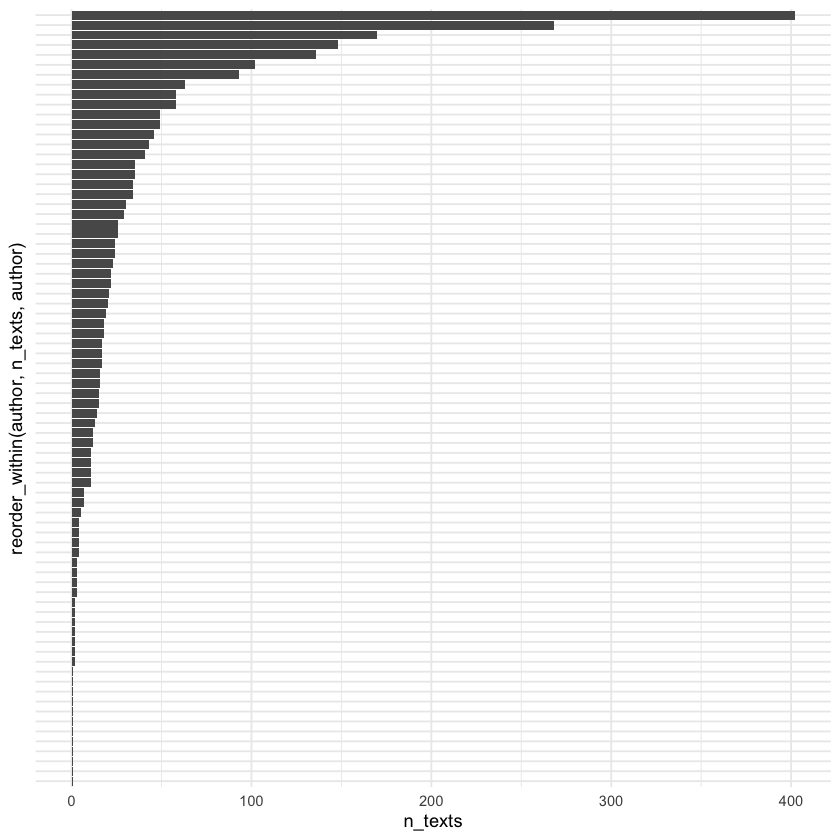

In [4]:
rnc_authors <- gamma %>% 
    filter(corpus == "N") %>% 
    mutate(decade = floor(as.numeric(year)/5)*5) %>% 
    filter(decade %in% c(1830, 1835)) %>% 
    group_by(author) %>% 
    summarise(n_gamma = sum(n()),
             n_texts = n_gamma/75) %>% 
    arrange(desc(n_texts))

rnc_authors %>% 
    ungroup() %>%
    summarise(total_texts = sum(n_texts))

rnc_authors <- rnc_authors %>% 
    mutate(percentage = n_texts/2467*100)

head(rnc_authors, 20)
summary(rnc_authors$n_texts)

rnc_authors %>% 
    ggplot(aes(x = n_texts, 
               y = reorder_within(author, n_texts, author))) + 
    geom_col() +
    theme(axis.text.y = element_blank())

In [7]:
# Gini index
library(ineq)
ineq(rnc_authors$n_texts, type = "Gini")

[1] 0.6812541

In [12]:
gamma_per_test <- gamma %>% 
    filter(corpus == "P") %>% 
    filter(year > 1829 & year < 1840) %>% 
    group_by(author) %>% 
    summarise(n_gamma = sum(n()),
             n_texts = n_gamma/75) %>% 
    arrange(desc(n_texts)) %>% 
    ungroup()

# gamma_per_test %>% 
#    summarise(total_text = sum(n_texts)) # 1191

gamma_per_test %>% 
    filter(author != "NA") %>% 
    mutate(percentage = n_texts/1191*100) %>% 
    head(15)

ineq(gamma_per_test$n_texts, type = "Gini")

author,n_gamma,n_texts,percentage
<chr>,<int>,<dbl>,<dbl>
ТимофеевАВ,3525,47,3.946264
КозловИИ,2925,39,3.274559
МенцовФН,2700,36,3.022670
ЯкубовичЛА,2700,36,3.022670
БернетЕ,2325,31,2.602855
КропоткинДА,2025,27,2.267003
РостопчинаЕП,2025,27,2.267003
ГлинкаФН,1950,26,2.183039
СоколовскийВИ,1800,24,2.015113


[1] 0.6359284

Sampling

In [6]:
# filter overpresented authors
top_authors <- rnc_authors %>% 
    filter(n_texts > 30) %>% select(author) # 19 authors

# randomly select 30 texts by each author
sampled_id <- gamma %>% 
    filter(corpus == "N") %>% 
    # select slice
    filter(year > 1829 & year < 1840) %>%
    select(index, author) %>% 
    distinct() %>% 
    filter(author %in% top_authors$author) %>% 
    group_by(author) %>% 
    sample_n(30) %>% 
    ungroup() %>%
    select(-author)

# retrieve gamma values for samples for these authors
gamma_top <- inner_join(sampled_id, gamma, by = "index", multiple = "all")

Merging

In [7]:
# select texts from RNC by non-prevalent authors
gamma_nontop <- gamma %>% 
    filter(corpus == "N" & !author %in% top_authors$author) %>% 
    filter(year > 1829 & year < 1840)

# retrieve all the gamma values for texts from periodicals
gamma_periodicals <- gamma %>% 
    filter(corpus == "P") %>% 
    filter(year > 1829 & year < 1840) 

# merge the three together
gamma1830 <- rbind(gamma_top, gamma_nontop, gamma_periodicals)

head(gamma1830)

print("Number of texts in each corpus after sampling:")
gamma1830 %>% 
    select(index, corpus) %>% 
    distinct() %>% 
    group_by(corpus) %>% 
    count()

index,corpus,id,year,author,formula,topic,gamma
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,1,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,2,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,3,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,4,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,5,0.008695652
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,6,0.008695652


[1] "Number of texts in each corpus after sampling:"


corpus,n
<chr>,<int>
N,1173
P,1191


In [8]:
save(gamma1830, file = "../data/gamma_1830.Rda")

## Preparation of nodes & edges

In [2]:
load("../data/gamma_1830.Rda")
glimpse(gamma1830)

Rows: 177,300
Columns: 8
$ index   <chr> "N_6701-1", "N_6701-1", "N_6701-1", "N_6701-1", "N_6701-1", "N…
$ corpus  <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N…
$ id      <chr> "6701-1", "6701-1", "6701-1", "6701-1", "6701-1", "6701-1", "6…
$ year    <chr> "1830", "1830", "1830", "1830", "1830", "1830", "1830", "1830"…
$ author  <chr> "АВКольцов", "АВКольцов", "АВКольцов", "АВКольцов", "АВКольцов…
$ formula <chr> "anapaest_регулярная:2+1", "anapaest_регулярная:2+1", "anapaes…
$ topic   <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…
$ gamma   <dbl> 0.008695652, 0.008695652, 0.008695652, 0.008695652, 0.00869565…


Extract topic labels & Create edges: detect highly probable topics appeared in the same poems

In [5]:
topic_labels <- get_topic_labels(beta, n_labels = 5)
head(topic_labels)

edges_1830 <- compute_edges(gamma1830,
                           gamma_thresh = 0.05,
                           time_slice = 5)

head(edges_1830)

topic,label
<int>,<chr>
1,1_старик девица красный молодой старый
2,2_брат два жена муж другой
3,3_искать исчезать везде дух след
4,4_дева прекрасный краса чистый молодой
5,5_бог давать сила боже господь
6,6_слава великий герой отечество россия


index,corpus,id,year,author,formula,topic,gamma,from,to,slice,edge_id,source,target
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,23,0.06086957,23,25,1830,23 25,23_белый грудь черный лицо кудри,25_взор око речь взгляд улыбка
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,23,0.06086957,23,34,1830,23 34,23_белый грудь черный лицо кудри,34_слеза сердце плакать тоска печаль
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,23,0.06086957,23,37,1830,23 37,23_белый грудь черный лицо кудри,37_огонь пламень грудь гореть око
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,23,0.06086957,23,56,1830,23 56,23_белый грудь черный лицо кудри,56_рука нога голова глаз подымать
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,25,0.04347826,25,34,1830,25 34,25_взор око речь взгляд улыбка,34_слеза сердце плакать тоска печаль
N_6701-1,N,6701-1,1830,АВКольцов,anapaest_регулярная:2+1,25,0.04347826,25,37,1830,25 37,25_взор око речь взгляд улыбка,37_огонь пламень грудь гореть око


In [6]:
# select top meters
meter_counts_1830 <- gamma1830 %>% 
  rename("meter" = "formula") %>% 
  filter(!str_detect(meter, "other") & meter != "NA") %>% 
  group_by(meter, corpus) %>% 
  count(sort = T) %>% 
  mutate(n_texts = n/75) %>%
  ungroup() %>% 
  filter(n > 10)

head(meter_counts_1830, 20)

top_meters_1830 <- meter_counts_1830 %>% 
  group_by(meter) %>%
  summarise(total = sum(n)) %>% 
  arrange(desc(total))

head(top_meters_1830, 15)
top_meters_1830$meter[1:8]

meter,corpus,n,n_texts
<chr>,<chr>,<int>,<dbl>
iamb_4,N,24675,329
iamb_4,P,24375,325
iamb_free,P,21975,293
trochee_4,P,11700,156
trochee_4,N,10950,146
iamb_free,N,10500,140
iamb_5,N,9300,124
iamb_6,N,6150,82
iamb_6,P,4875,65


meter,total
<chr>,<int>
iamb_4,49050
iamb_free,32475
trochee_4,22650
iamb_5,13275
iamb_6,11025
amphibrach_4,6750
trochee_free,3675
amphibrach_free,2550
anapaest_free,2400


[1] "iamb_4"          "iamb_free"       "trochee_4"       "iamb_5"         
[5] "iamb_6"          "amphibrach_4"    "trochee_free"    "amphibrach_free"

In [7]:
links_1830 <- edges_1830 %>% 
  mutate(meter = formula) %>%
  # filter out only 8 most interesting meters
  filter(meter %in% top_meters_1830$meter[1:8]) %>% 
  # group and count edges
  group_by(meter, corpus) %>% 
  count(meter, edge_id, source, target, sort = T) %>% 
  # filter non-frequent edges
  filter(n > 2) %>% 
  ungroup() 

# quick check
head(links_1830)

meter,corpus,edge_id,source,target,n
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
iamb_free,P,30 42,30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,10
iamb_4,P,8 74,8_звезда небо луна ночь луч,74_луч солнце небо заря блистать,9
iamb_4,N,30 42,30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,8
iamb_4,P,24 72,24_вода луг тень ручей роща,72_гора лес скала дикий стоять,8
iamb_4,P,30 74,30_небо земля мир земной небесный,74_луч солнце небо заря блистать,8
trochee_4,P,8 26,8_звезда небо луна ночь луч,26_волна море берег вода брег,8


Create node- and edgelist

In [8]:
edgelist <- links_1830 %>% 
  select(source, target, n, meter, corpus) %>% 
  mutate(width = n/10)

nodelist <- tibble(source = unique(c(links_1830$target, 
                                     links_1830$source))) %>% 
  mutate(idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1"))) 

head(edgelist)
head(nodelist) 
nrow(nodelist)

source,target,n,meter,corpus,width
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>
30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,10,iamb_free,P,1.0
8_звезда небо луна ночь луч,74_луч солнце небо заря блистать,9,iamb_4,P,0.9
30_небо земля мир земной небесный,42_душа мечта поэт живой восторг,8,iamb_4,N,0.8
24_вода луг тень ручей роща,72_гора лес скала дикий стоять,8,iamb_4,P,0.8
30_небо земля мир земной небесный,74_луч солнце небо заря блистать,8,iamb_4,P,0.8
8_звезда небо луна ночь луч,26_волна море берег вода брег,8,trochee_4,P,0.8


source,idn
<chr>,<dbl>
42_душа мечта поэт живой восторг,42
74_луч солнце небо заря блистать,74
72_гора лес скала дикий стоять,72
26_волна море берег вода брег,26
55_душа жизнь страсть страдание мука,55
75_сердце душа любовь дар радость,75


[1] 73

## Networks visualisations

### Create network

In [17]:
net1830 <- graph_from_data_frame(d = edgelist, vertices = nodelist, directed = F)
net1830

IGRAPH 77f8715 UN-- 73 638 -- 
+ attr: name (v/c), idn (v/n), n (e/n), meter (e/c), corpus (e/c),
| width (e/n)
+ edges from 77f8715 (vertex names):
[1] 42_душа мечта поэт живой восторг--30_небо земля мир земной небесный     
[2] 74_луч солнце небо заря блистать--8_звезда небо луна ночь луч           
[3] 42_душа мечта поэт живой восторг--30_небо земля мир земной небесный     
[4] 72_гора лес скала дикий стоять  --24_вода луг тень ручей роща           
[5] 74_луч солнце небо заря блистать--30_небо земля мир земной небесный     
[6] 26_волна море берег вода брег   --8_звезда небо луна ночь луч           
[7] 42_душа мечта поэт живой восторг--12_любовь сердце страсть кровь чувство
+ ... omitted several edges

### networks viz

In [22]:
# function for network visualisation

# taken as input net, meter as a string & colour palette value
# corpus is "N" for RNC, "P" for periodicals

network <- function(network, meter_value, palette_v) {
  ggraph(network, layout = "stress") +
    geom_edge_fan(aes(color = meter,
                      filter = meter %in% c(meter_value), 
                      width = n, 
                      alpha = 0.4)) +
    geom_node_point() +
    geom_node_text(aes(label=idn), 
                   hjust=0.1, 
                   vjust=-0.4, 
                   size=3, 
                   color="grey50") +
    theme_void() + 
    theme(strip.text = element_text(size = 12)) +
    facet_wrap(~corpus, 
               scales="free_x", 
               drop=T,
               ncol = 5) + 
    scale_edge_color_manual(values = palette_v) + 
    labs(title = meter_value) + 
    theme(legend.position = "None")
}

In [23]:
unique(edgelist$meter)

[1] "iamb_free"       "iamb_4"          "trochee_4"       "amphibrach_4"   
[5] "iamb_5"          "iamb_6"          "trochee_free"    "amphibrach_free"

In [24]:
plot_values <- tibble(mv = c("iamb_4", "trochee_4", "iamb_6", "iamb_5", "iamb_free"),
                     cv = c(wes_palette("Darjeeling1")[2], 
                            wes_palette("Darjeeling1")[1],
                            wes_palette("Darjeeling1")[3], 
                            wes_palette("Royal1")[1],
                            wes_palette("Darjeeling1")[4]))



In [25]:
plotlist <- list()

for (i in 1:5) {
    p <- network(net1830, plot_values$mv[i], plot_values$cv[i])
    plotlist[[i]] <- p
    ggsave(filename = paste0("../plots/03_02_network_", 
                             plot_values$mv[i], 
                             ".png"), 
           plot = p,
           height = 6, width = 8, bg = "white")
}

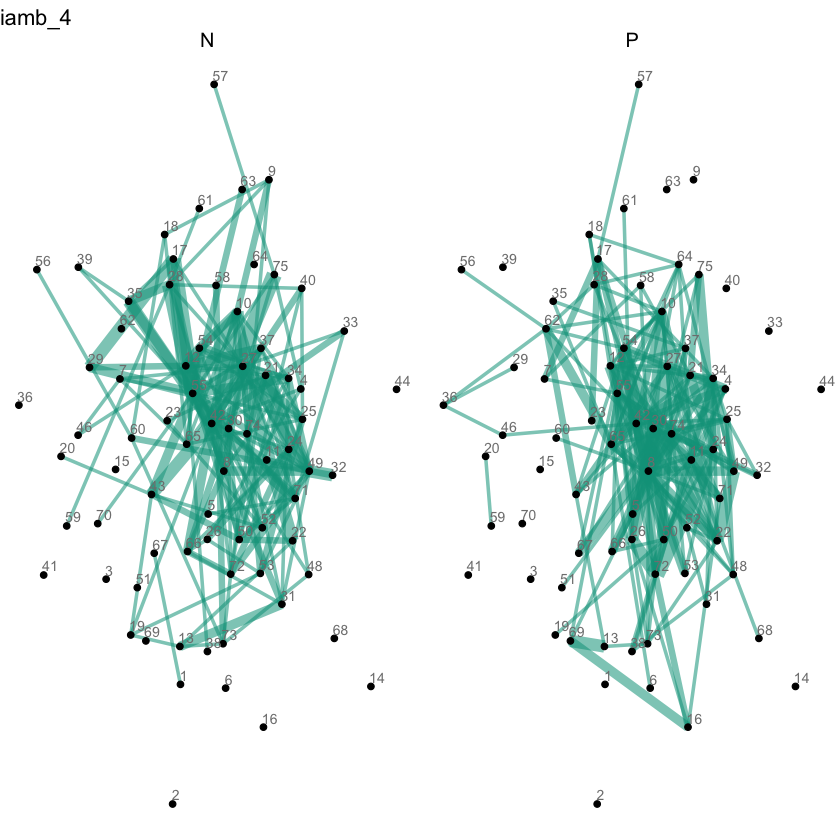

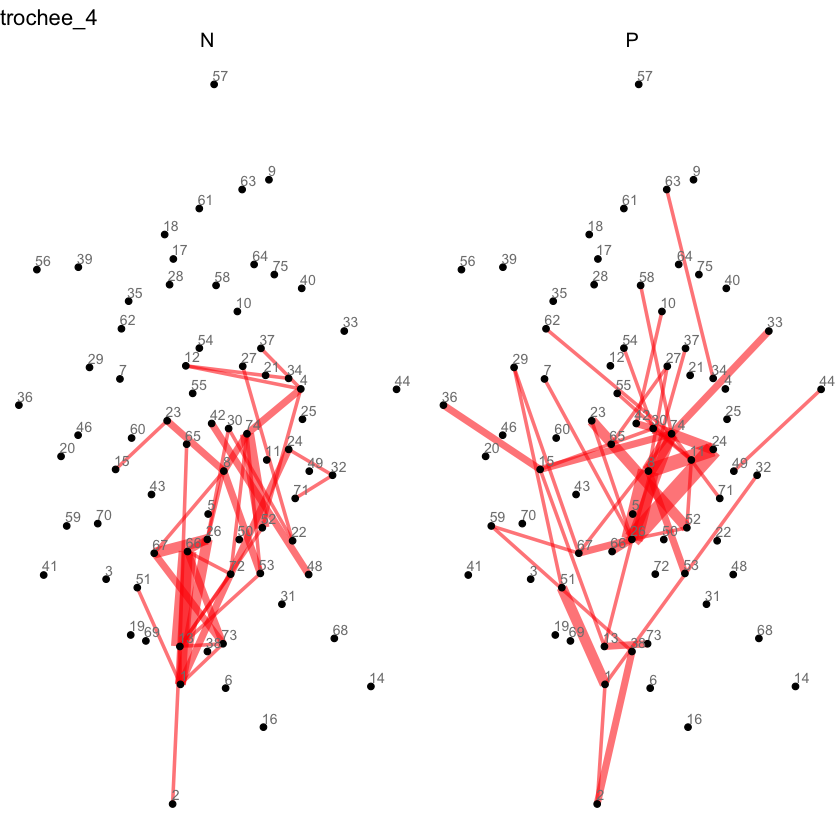

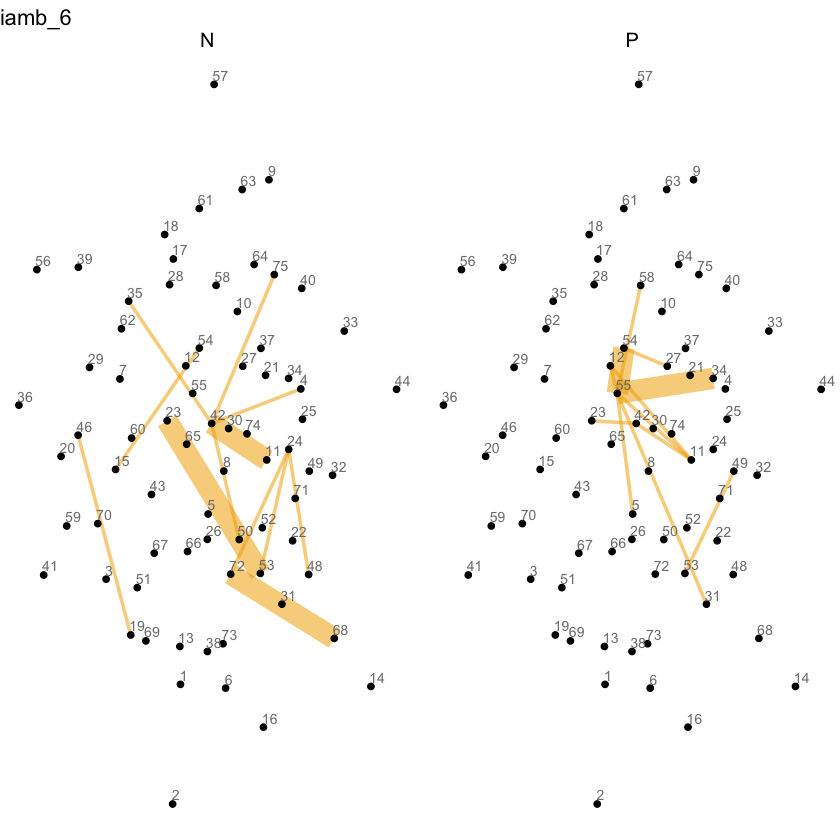

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


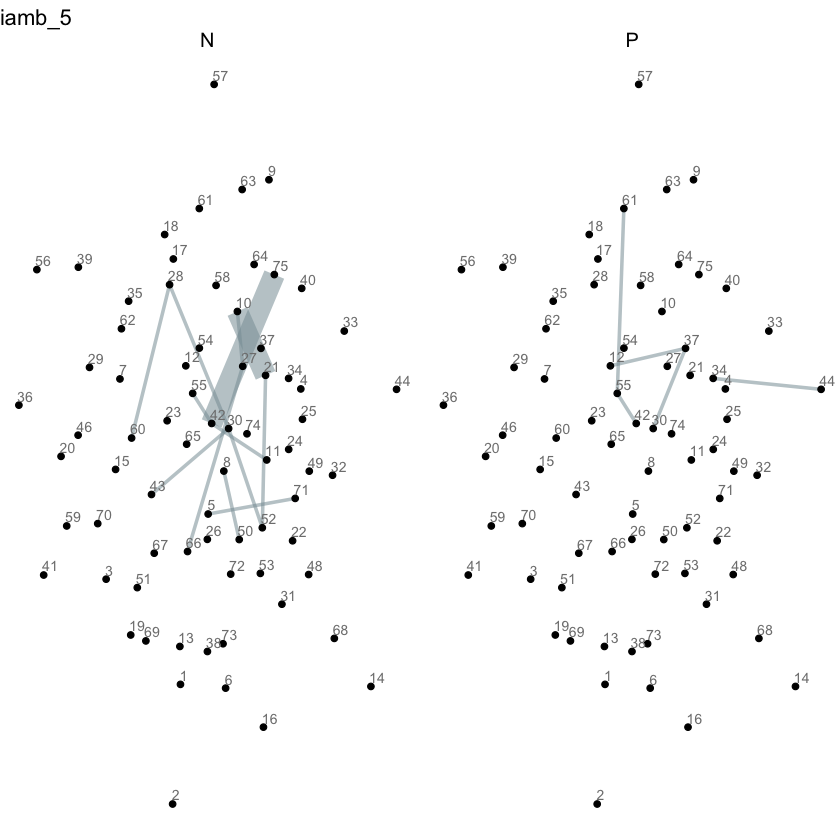

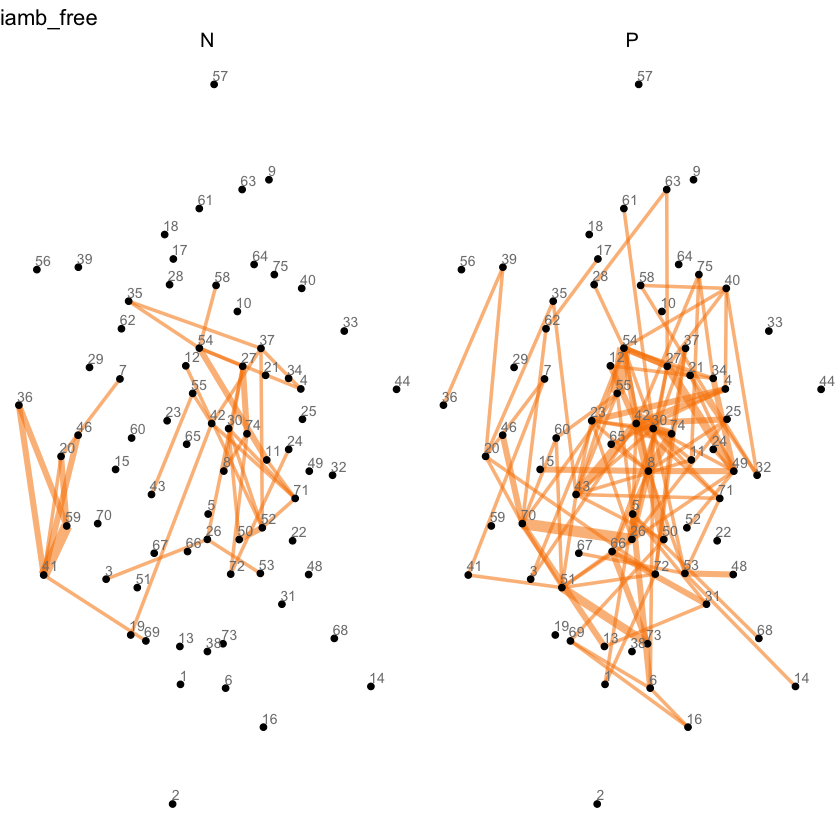

In [26]:
plotlist

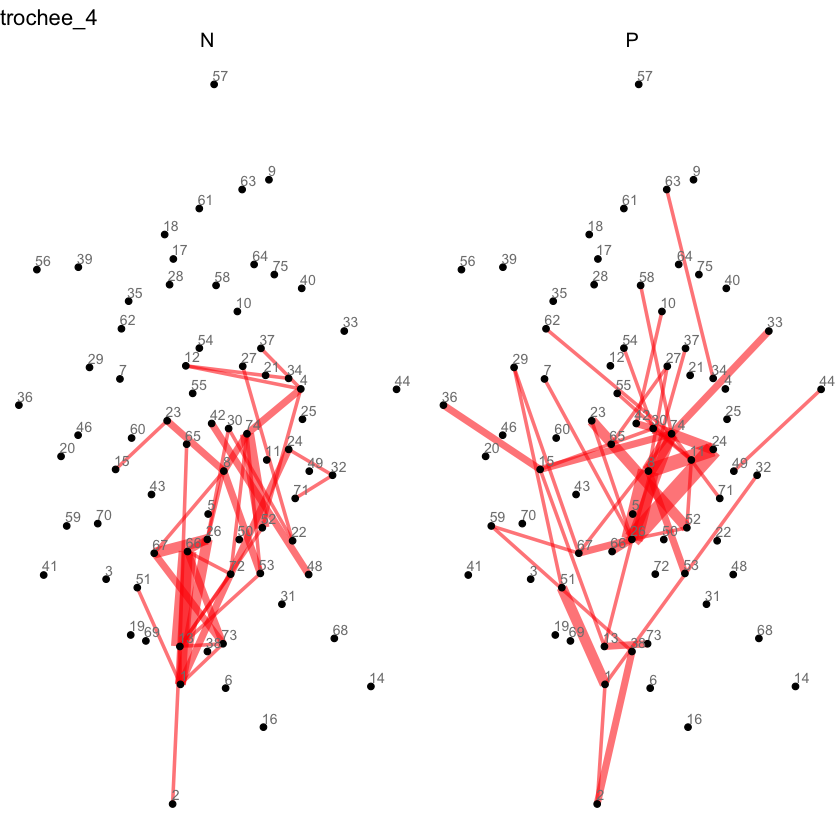

In [27]:
plotlist[[2]]

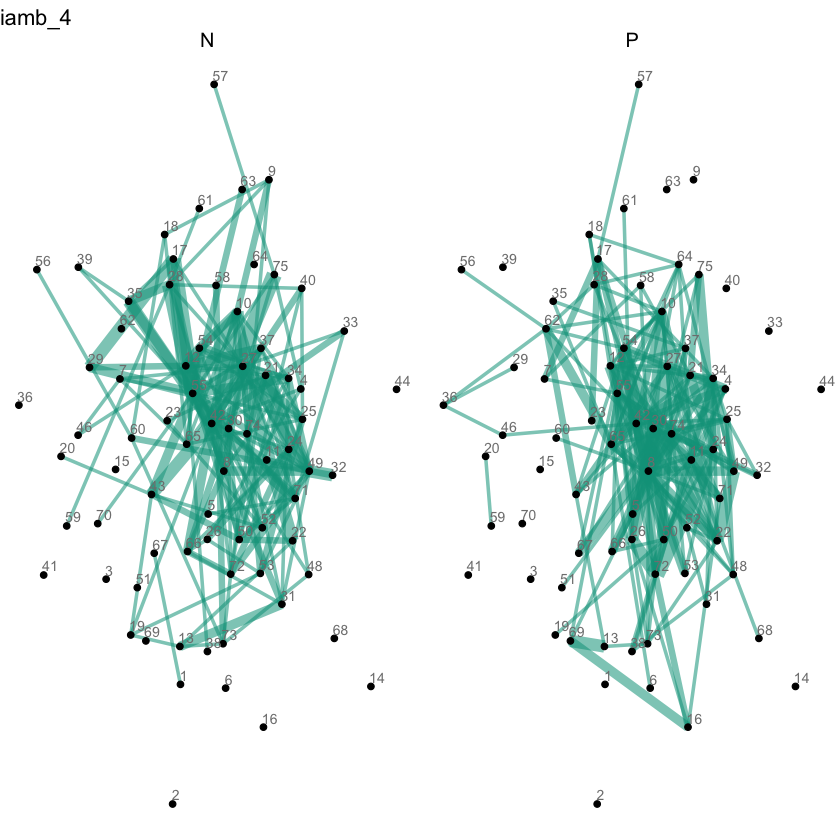

In [37]:
plotlist[[1]]

### Analysis

Degree and betweenness

In [9]:
degree_betweenness <- function(formula, subcorpus) {
    # create network for selected meter
    net_temp <- graph_from_data_frame(d=edgelist %>% 
                                          filter(meter == formula, corpus == subcorpus),
                                      vertices = nodelist,
                                      directed = F)

    ## betweenness
    # extract betweenness stats
    betw <- igraph::betweenness(net_temp)

    # named vector to tibble
    # str(betw)
    betw_tib <- as_tibble(as.list(betw)) %>% 
      mutate(x = "x") %>% 
      pivot_longer(!x, names_to = "source", values_to = "betw_meter") %>% 
      select(-x)

    # attach betweenness values to nodelist
    nodelist_temp <- inner_join(nodelist, betw_tib, by = "source") %>% 
        mutate(meter = formula)

    ## degree
    # extract degree values
    deg <- igraph::degree(net_temp, mode="all")

    degree_tib <- as_tibble(as.list(deg)) %>% 
      mutate(x = "x") %>% 
      pivot_longer(!x, names_to = "source", values_to = "degree_meter") %>% 
      select(-x)

    # attach degree to nodelist
    nodelist_result <- inner_join(nodelist_temp, degree_tib, by = "source")

    nodelist_result
}

In [56]:
print("Top-10 nodes by degree")
print("Periodicals")
degree_betweenness("iamb_4", "P") %>% arrange(desc(degree_meter)) %>% head(10)
print("RNC")
degree_betweenness("iamb_4", "N") %>% arrange(desc(degree_meter)) %>% head(10)

[1] "Top-10 nodes by degree"
[1] "Periodicals"


source,idn,betw_meter,meter,degree_meter
<chr>,<dbl>,<dbl>,<chr>,<dbl>
8_звезда небо луна ночь луч,8,385.19520,iamb_4,28
42_душа мечта поэт живой восторг,42,289.65401,iamb_4,21
74_луч солнце небо заря блистать,74,98.75843,iamb_4,18
55_душа жизнь страсть страдание мука,55,162.50424,iamb_4,15
65_край страна родной чужой далекий,65,155.74455,iamb_4,14
30_небо земля мир земной небесный,30,136.98553,iamb_4,13
34_слеза сердце плакать тоска печаль,34,120.61528,iamb_4,13
54_жизнь радость надежда день мечта,54,51.04183,iamb_4,12
27_сердце дума душа тоска полный,27,24.20361,iamb_4,11


[1] "RNC"


source,idn,betw_meter,meter,degree_meter
<chr>,<dbl>,<dbl>,<chr>,<dbl>
55_душа жизнь страсть страдание мука,55,395.30791,iamb_4,25
42_душа мечта поэт живой восторг,42,332.08433,iamb_4,22
27_сердце дума душа тоска полный,27,181.16678,iamb_4,20
49_гроб могила прах земля мертвый,49,140.53739,iamb_4,14
12_любовь сердце страсть кровь чувство,12,152.35876,iamb_4,13
10_пора день память помнить забывать,10,63.97452,iamb_4,11
30_небо земля мир земной небесный,30,29.06940,iamb_4,10
24_вода луг тень ручей роща,24,52.10828,iamb_4,9
50_петь песня звук песнь певец,50,31.57855,iamb_4,9


In [57]:
print("Top-10 nodes by degree")
print("Periodicals")
degree_betweenness("trochee_4", "P") %>% arrange(desc(degree_meter)) %>% head(10)
print("RNC")
degree_betweenness("trochee_4", "N") %>% arrange(desc(degree_meter)) %>% head(10)

[1] "Top-10 nodes by degree"
[1] "Periodicals"


source,idn,betw_meter,meter,degree_meter
<chr>,<dbl>,<dbl>,<chr>,<dbl>
74_луч солнце небо заря блистать,74,256.66667,trochee_4,10
26_волна море берег вода брег,26,204.33333,trochee_4,10
30_небо земля мир земной небесный,30,121.66667,trochee_4,5
8_звезда небо луна ночь луч,8,92.00000,trochee_4,5
67_лететь крыло орел птица летать,67,185.00000,trochee_4,4
15_пить вино чаша пир гость,15,47.00000,trochee_4,4
11_святой молитва вера храм божий,11,38.66667,trochee_4,3
24_вода луг тень ручей роща,24,0.00000,trochee_4,3
52_грудь уста сладкий нега слеза,52,27.00000,trochee_4,3


[1] "RNC"


source,idn,betw_meter,meter,degree_meter
<chr>,<dbl>,<dbl>,<chr>,<dbl>
13_меч бой враг герой поле,13,75.16667,trochee_4,8
1_старик девица красный молодой старый,1,43.50000,trochee_4,6
74_луч солнце небо заря блистать,74,80.00000,trochee_4,5
72_гора лес скала дикий стоять,72,76.50000,trochee_4,5
26_волна море берег вода брег,26,77.83333,trochee_4,5
66_буря туча гром небо ветер,66,19.50000,trochee_4,5
8_звезда небо луна ночь луч,8,78.66667,trochee_4,5
73_конь дорога поле бежать лететь,73,7.00000,trochee_4,4
4_дева прекрасный краса чистый молодой,4,68.00000,trochee_4,4


In [10]:
print("Top-10 nodes by degree")
print("Periodicals")
degree_betweenness("iamb_6", "P") %>% arrange(desc(degree_meter)) %>% head(10)
print("RNC")
degree_betweenness("iamb_6", "N") %>% arrange(desc(degree_meter)) %>% head(10)

[1] "Top-10 nodes by degree"
[1] "Periodicals"


source,idn,betw_meter,meter,degree_meter
<chr>,<dbl>,<dbl>,<chr>,<dbl>
55_душа жизнь страсть страдание мука,55,38,iamb_6,7
11_святой молитва вера храм божий,11,16,iamb_6,3
42_душа мечта поэт живой восторг,42,9,iamb_6,2
54_жизнь радость надежда день мечта,54,9,iamb_6,2
12_любовь сердце страсть кровь чувство,12,0,iamb_6,2
27_сердце дума душа тоска полный,27,0,iamb_6,1
49_гроб могила прах земля мертвый,49,0,iamb_6,1
31_враг смерть страшный ужасный кровь,31,0,iamb_6,1
53_сон спать ночь просыпаться тишина,53,0,iamb_6,1


[1] "RNC"


source,idn,betw_meter,meter,degree_meter
<chr>,<dbl>,<dbl>,<chr>,<dbl>
42_душа мечта поэт живой восторг,42,10,iamb_6,5
24_вода луг тень ручей роща,24,8,iamb_6,3
72_гора лес скала дикий стоять,72,4,iamb_6,2
53_сон спать ночь просыпаться тишина,53,4,iamb_6,2
75_сердце душа любовь дар радость,75,0,iamb_6,1
11_святой молитва вера храм божий,11,0,iamb_6,1
54_жизнь радость надежда день мечта,54,0,iamb_6,1
35_толпа свет смех игра забава,35,0,iamb_6,1
50_петь песня звук песнь певец,50,0,iamb_6,1


Top connections in Iamb-4 and Trochee-4 by corpus

In [11]:
links_1830 %>% 
    filter(corpus == "P" & meter %in% c("trochee_4", "iamb_4", "iamb_6")) %>% 
    group_by(meter) %>% 
    top_n(5, n) %>% 
    arrange(desc(n)) %>%
    arrange(desc(meter)) %>% 
    arrange(desc(corpus))

meter,corpus,edge_id,source,target,n
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
trochee_4,P,8 26,8_звезда небо луна ночь луч,26_волна море берег вода брег,8
trochee_4,P,24 26,24_вода луг тень ручей роща,26_волна море берег вода брег,7
trochee_4,P,8 24,8_звезда небо луна ночь луч,24_вода луг тень ручей роща,6
trochee_4,P,8 74,8_звезда небо луна ночь луч,74_луч солнце небо заря блистать,6
trochee_4,P,1 51,1_старик девица красный молодой старый,51_сидеть окно дверь дом стоять,5
trochee_4,P,23 52,23_белый грудь черный лицо кудри,52_грудь уста сладкий нега слеза,5
trochee_4,P,24 74,24_вода луг тень ручей роща,74_луч солнце небо заря блистать,5
trochee_4,P,26 74,26_волна море берег вода брег,74_луч солнце небо заря блистать,5
trochee_4,P,30 74,30_небо земля мир земной небесный,74_луч солнце небо заря блистать,5


In [12]:
links_1830 %>% 
    filter(corpus == "N" & meter %in% c("trochee_4", "iamb_4", "iamb_6")) %>% 
    group_by(meter) %>% 
    top_n(5, n) %>% 
    arrange(desc(n)) %>%
    arrange(desc(meter)) %>% 
    arrange(desc(corpus))

meter,corpus,edge_id,source,target,n
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
trochee_4,N,13 66,13_меч бой враг герой поле,66_буря туча гром небо ветер,7
trochee_4,N,52 74,52_грудь уста сладкий нега слеза,74_луч солнце небо заря блистать,6
trochee_4,N,1 26,1_старик девица красный молодой старый,26_волна море берег вода брег,5
trochee_4,N,1 66,1_старик девица красный молодой старый,66_буря туча гром небо ветер,5
trochee_4,N,26 67,26_волна море берег вода брег,67_лететь крыло орел птица летать,5
iamb_6,N,11 42,11_святой молитва вера храм божий,42_душа мечта поэт живой восторг,4
iamb_6,N,23 53,23_белый грудь черный лицо кудри,53_сон спать ночь просыпаться тишина,4
iamb_6,N,68 72,68_зреть глава глас внимать вещать,72_гора лес скала дикий стоять,4
iamb_6,N,15 54,15_пить вино чаша пир гость,54_жизнь радость надежда день мечта,3


#### N edges & density

In [14]:
# Number of edges

print("Number of connections by each meter")
edgelist %>% 
    filter(meter %in% c("iamb_4", "iamb_6", "trochee_4")) %>% 
    group_by(meter, corpus) %>% 
    count(sort = F) %>% 
    pivot_wider(names_from = corpus, values_from = n)

[1] "Number of connections by each meter"


meter,N,P
<chr>,<int>,<int>
iamb_4,165,185
iamb_6,12,12
trochee_4,39,44


In [13]:
density_vector <- function(formula) {
    densities <- vector()
    e1 <- NULL
    for (i in 1:length(unique(edgelist$corpus))) {
        e1 <- edgelist %>% 
            filter(meter == formula & corpus == unique(edgelist$corpus)[i])

            net_test <- graph_from_data_frame(d = e1, vertices = nodelist, directed = F)

            densities[i] <- edge_density(net_test, loops = F)
    }
    densities
}

In [15]:
tibble(corpus = c("P", "N"),
      iamb_4 = round(density_vector("iamb_4"), 3),
      iamb_6 = round(density_vector("iamb_6"), 3),
      trochee_4 = round(density_vector("trochee_4"), 3),
      )

corpus,iamb_4,iamb_6,trochee_4
<chr>,<dbl>,<dbl>,<dbl>
P,0.070,0.005,0.017
N,0.063,0.005,0.015


#### Comparison of connections

In [60]:
links_n <- links_1830 %>% 
  filter(corpus == "N" & meter %in% c("iamb_4", "iamb_6", "iamb_free", "trochee_4")) %>% 
  mutate(connection = paste0(meter, "__", edge_id)) %>% 
  select(connection) 

links_p <- links_1830 %>% 
  filter(corpus == "P" & meter %in% c("iamb_4", "iamb_6", "iamb_free", "trochee_4")) %>% 
  mutate(connection = paste0(meter, "__", edge_id)) %>% 
  select(connection) 
  
t <- intersect(links_n$connection, links_p$connection)

head(t)
length(t)



[1] "iamb_4__30 42" "iamb_4__12 42" "iamb_4__10 27" "iamb_4__12 55"
[5] "iamb_4__21 24" "iamb_4__27 54"

[1] 59

In [64]:
links_1830 %>% 
  filter(meter %in% c("iamb_4", "iamb_6", "iamb_free", "trochee_4")) %>% 
  mutate(connection = paste0(meter, "__", edge_id)) %>% 
  mutate(corpus_new = ifelse(connection %in% t, "Both", corpus)) %>% 
  mutate(corpus_new = recode(corpus_new, 
                           "N" = "National corpus", 
                           "P" = "Periodicals")) %>% 
  group_by(corpus_new, meter) %>% 
  count()

corpus_new,meter,n
<chr>,<chr>,<int>
Both,iamb_4,84
Both,iamb_6,2
Both,iamb_free,18
Both,trochee_4,14
National corpus,iamb_4,123
National corpus,iamb_6,11
National corpus,iamb_free,27
National corpus,trochee_4,32
Periodicals,iamb_4,143


In [74]:
links_1830 %>% 
  filter(meter %in% c("iamb_4", "iamb_6", "iamb_free", "trochee_4")) %>% 
  mutate(connection = paste0(meter, "__", edge_id)) %>% 
  mutate(corpus_new = ifelse(connection %in% t, "Both", corpus)) %>% 
  mutate(corpus_new = recode(corpus_new, 
                           "N" = "National corpus", 
                           "P" = "Periodicals")) %>% 
  # first select unique connections and assign to both/P/N
  group_by(corpus_new, meter, edge_id) %>%
  count() %>% 
  select(-n) %>% 
  distinct() %>%
  # ungroup & count by large groups again
  ungroup() %>% 
  group_by(corpus_new, meter) %>% 
  count(sort = T) %>% 
  arrange(desc(meter))

corpus_new,meter,n
<chr>,<chr>,<int>
Periodicals,trochee_4,37
National corpus,trochee_4,32
Both,trochee_4,7
Periodicals,iamb_free,105
National corpus,iamb_free,27
Both,iamb_free,9
National corpus,iamb_6,11
Periodicals,iamb_6,11
Both,iamb_6,1


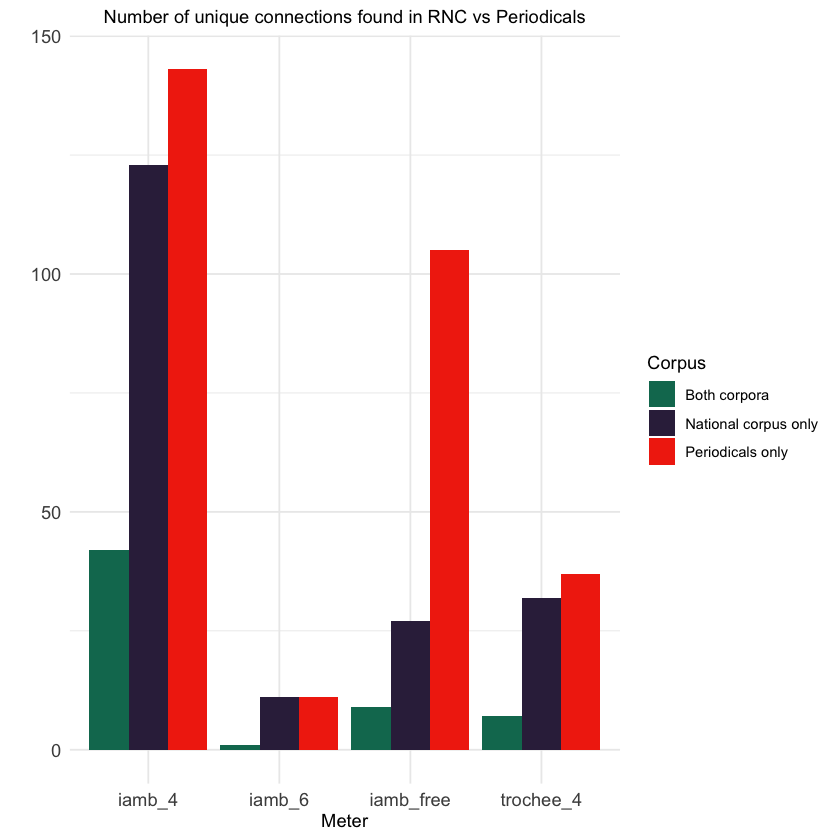

In [78]:
links_1830 %>% 
  filter(meter %in% c("iamb_4", "iamb_6", "iamb_free", "trochee_4")) %>% 
  mutate(connection = paste0(meter, "__", edge_id)) %>% 
  mutate(corpus_new = ifelse(connection %in% t, "Both corpora", corpus)) %>% 
  mutate(corpus_new = recode(corpus_new, 
                           "N" = "National corpus only", 
                           "P" = "Periodicals only")) %>% 
  # first select unique connections and assign to both/P/N
  group_by(corpus_new, meter, edge_id) %>%
  count() %>% 
  select(-n) %>% 
  distinct() %>%
  # ungroup & count by large groups again
  ungroup() %>% 
  group_by(corpus_new, meter) %>% 
  count(sort = T) %>% 
  arrange(desc(meter)) %>% 
  ggplot(aes(x = meter,
           y = n,
           group = corpus_new,
           fill = corpus_new)) +
  geom_col(position = "dodge") +
  labs(x = "Meter",
       y = "", 
       fill = "Corpus",
       subtitle = "Number of unique connections found in RNC vs Periodicals") + 
  scale_fill_manual(values = c(wes_palette("Rushmore1")[3:5])) + 
  theme(axis.text = element_text(size = 11), 
        plot.subtitle = element_text(hjust = 0.5))

In [40]:
tr4_p <- tbl_graph(nodelist, edgelist %>% filter(meter == "iamb_6" & corpus == "P"), directed = F)
tr4_n <- tbl_graph(nodelist, edgelist %>% filter(meter == "iamb_6" & corpus == "N"), directed = F)

In [42]:
is_isomorphic_to(tr4_p, tr4_n)

[1] FALSE

In [48]:
diameter(tr4_p)
diameter(tr4_n)

[1] 5

[1] 4

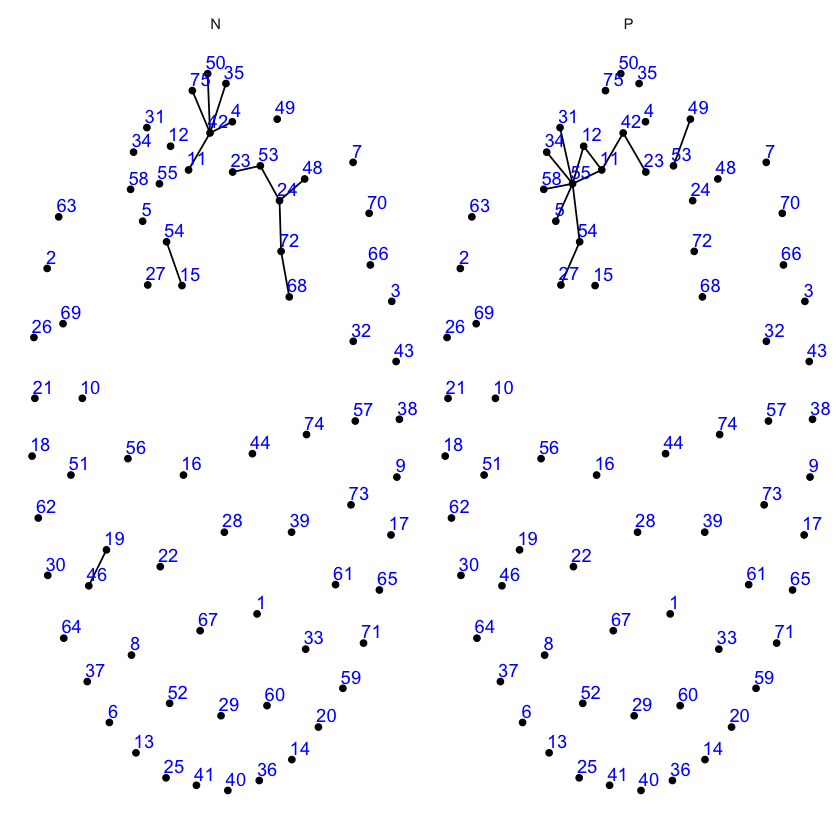

In [53]:
net6 <- tbl_graph(nodelist, edgelist %>% filter(meter == "iamb_6"), directed = F)

ggraph(net6, 'kk') + 
    geom_node_point() + 
    geom_edge_fan() + 
    geom_node_text(aes(label=idn), 
                   hjust=0.1, 
                   vjust=-0.4,
                   color = "blue") +
    facet_wrap(~corpus)

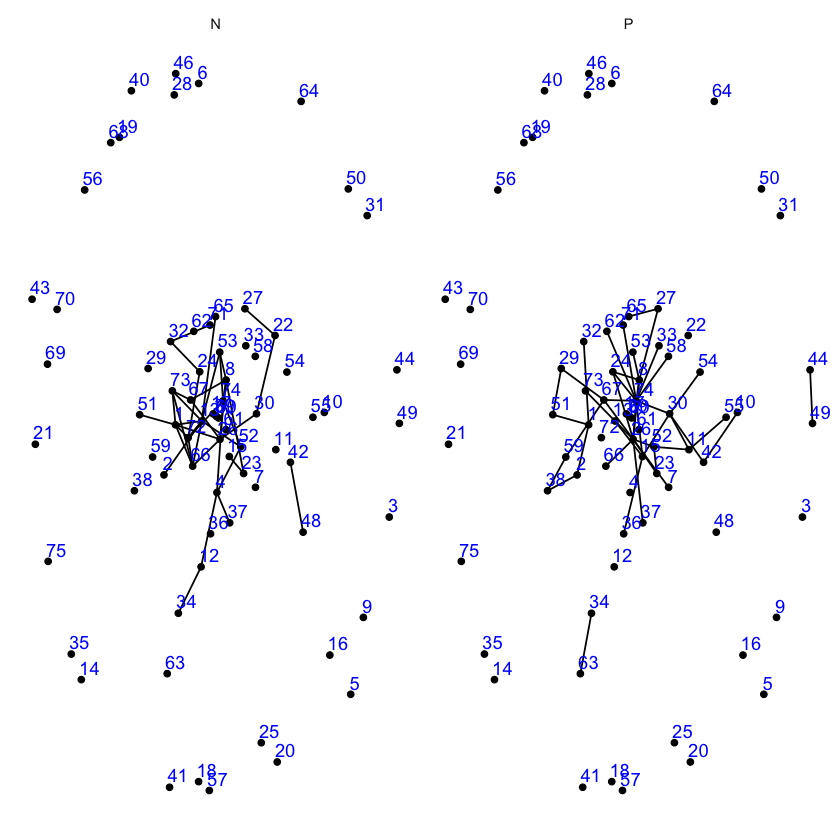

In [54]:
net4 <- tbl_graph(nodelist, edgelist %>% filter(meter == "trochee_4"), directed = F)

ggraph(net4, 'kk') + 
    geom_node_point() + 
    geom_edge_fan() + 
    geom_node_text(aes(label=idn), 
                   hjust=0.1, 
                   vjust=-0.4,
                   color = "blue") +
    facet_wrap(~corpus)